# XGBoost Regression from Scratch

The Gradient Boosting (GB) algorithm trains a series of weak learners and each focuses on the errors the previous learners have made and tries to improve it. Together, they make a better prediction.

According to Wikipedia, Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion as other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. 

Prerequisite

    1. Linear regression and gradient descent
    2. Decision Tree

After studying this post, you will be able to:

    1. Explain gradient boosting algorithm.
    2. Explain gradient boosting regression algorithm.
    3. Write a gradient boosting regressor from scratch


    
# The algorithm

The following plot illustrates the algorithm.

![Gradient Boosting Regression](gradient_boosting/gradient_boosting_regression.png)

From the plot above, the first part is a stump, which is the average of **y**. We then add several trees to it. In the following trees, the target is not y. Instead, the target is the residual or the true value subtracts the previous prediction.

$$residual=true\_value - previous\_prediction$$

That is why we say in Gradient Boosting trains a series of weak learners, each focuses on the errors of the previous one. The residual predictions are multiplied by the learning rate (0.1 here) before added to the average.

---

**The Steps**

Step 1: Calculate the average of y. The average is also the first estimation of y:
$$F_0=0.5$$

Step 2 for m in 1 to M: <br />
  * Step 2.1: Compute so-call pseudo-residuals:
    $$r_{im}=y_i-F_{m-1}(x_i)$$
  * Step 2.2: Fit a regression tree $t_m(x)$ to pseudo-residuals and create terminal regions (leafs) $R_{jm}$ for $j=1...Jm$ <br />

  * Step 2.3: For each leaf of the tree, there are $p_j$ elements, compute $\gamma$ as following equation. <br />

$$\gamma_{im}=\frac{1}{p_j} \sum_{x_i \in R_{jm}} r_{im}$$

  * (In practise, the regression tree will do this for us.)

  * Step 2.4: Update the model with learning rate $\alpha$:
$$F_m(x)=F_{m-1}+\alpha\gamma_m$$


Step 3. Output $$F_M(x)$$

---

In practice the regression tree will average the leaf for us. Thus, Step 2.2 and 2.3 can be combined into one step. And the steps can be simplified:

---

**New The Steps**

Step 1: Calculate the average of y. The average is also the first estimation of y:
$$\bar{y}=\frac{1}{n} \sum_{i=1}^{n}y_i$$

$$F_0(x)=\bar{y}$$
Step 2 for m in 1 to M: <br />
  * Step 2.1: Compute so-call pseudo-residuals:
    $$r_{im}=y_i-F_{m-1}(x_i)$$
  * Step 2.2: Fit a regression tree $t_m(x)$ to pseudo-residuals

  * Step 2.3: Update the model with learning rate $\alpha$:
$$F_m(x)=F_{m-1}+\alpha t_m(x)$$


Step 3. Output $$F_M(x)$$

---

# (Optional) From XGBoost to XGBoost Regression

The above knowledge is enough for writing BGR code from scratch. But I want to explain more about gradient boosting. GB is a meta-algorithm that can be applied to both regression and classification. The above one is only a specific form for regression. In the following, I will introduce the general gradient boosting algorithm and deduce GBR from GB.

Let's first look at the GB steps

---

**The Steps**

Input: training set $\{(x_i, y_i)\}_{i=1}^{n}$, a differentiable loss function $L(y, F(x))$, number of iterations M

Algorithm:

Step 1: Initialize model with a constant value:

$$F_0(x)=0.5$$

Step 2 for m in 1 to M: <br />
  * Step 2.1: Compute so-call pseudo-residuals:
    $$r_{im}=-[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}]_{F(x)=F_{m-1}(x)}$$
  * Step 2.2: Fit a weak learner $h_m(x)$ to pseudo-residuals. and create terminal regions $R_{jm}$, for $j=1...J_m$<br />

  * Step 2.3: For each leaf of the tree, compute $\gamma$ as the following equation. Here $\hat{r}$ is the predicted residual produced by $h_m(x)$.<br />
$$\gamma_{jm}=\underset{\gamma}{\operatorname{argmin}}\sum_{x_i \in R_{jm}}^{n}L(y_i, F_{m-1}(x_i)+\gamma)$$

  * Step 2.4: Update the model with learning rate $\alpha$:
$$F_m(x)=F_{m-1}+\alpha\gamma_m$$


Step 3. Output $$F_M(x)$$

---

To deduce the GB to GBR, I simply define a loss function and solve the loss function in step 1, 2.1 and 2.3. We use sum of squared errror(SSE) as the loss function:

$$L(y, \gamma)=\frac{1}{2}\sum_{i=1}^{n}(y_i-\gamma)^2$$



For step 1:


$$F_0=0.5$$

For step 2.1:

$$r_{im}=-[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}]_{F(x)=F_{m-1}(x)}$$

$$=-[\frac{\partial \frac{1}{2}\sum_{i=1}^{n}(y_i-F_{m-1}(x_i))^2)}{\partial F_{m-1}(x_i)}]_{F(x)=F_{m-1}(x)}$$

(The chain rule)

$$=--2*\frac{1}{2}(y_i-F_{m-1}(x_i))$$
$$=y_i-F_{m-1}(x_i)$$

For step 2.3:

Similarly, the result is:

$$\gamma_{jm}=\frac{1}{p_j}\sum_{x_i \in R_j}r_{mi}$$

In [88]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import graphviz 
from sklearn import tree

## Load data

In [2]:
boston_dict=load_boston()
data = boston_dict['data']
target = boston_dict['target']
feature_names = boston_dict['feature_names']
info = boston_dict['DESCR']
print(info)
df = pd.DataFrame(data=data, columns=[feature_names])
df['ONE'] = 1
df['PRICE'] = np.array(target) 
display(df.head())
#display(df['ONE'])

X = df[feature_names].copy()
X['ONE'] = 1
X = X.values
#X = X/X.max(axis=0)


y=target
std=y.std()

y_max=max(y)
y_min=min(y)
y_mean=y.mean()

y=(y-y_mean)/std

#y=y/std

y=np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 11)

n_train=X_train.shape[0]
n_test=X_test.shape[0]
m=X_train.shape[1]
print(n_train, n_test, m)
del df['PRICE']
df['PRICE'] = np.array(y)
display(df.head(5))
feature_names_one=list(feature_names) + ["ONE"]
df_train=pd.DataFrame(data=X_train, columns=[feature_names_one])
df_train['PRICE'] = y_train

display(df_train.head())

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ONE,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,1,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,1,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,1,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,1,36.2


404 102 14


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ONE,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,1,0.159686
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,1,-0.101524
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,1,1.324247
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1,1.182758
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,1,1.487503


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ONE,PRICE
0,0.12579,45.0,3.44,0.0,0.437,6.556,29.1,4.5667,5.0,398.0,15.2,382.84,4.56,1.0,0.790943
1,0.47547,0.0,9.90,0.0,0.544,6.113,58.8,4.0019,4.0,304.0,18.4,396.23,12.73,1.0,-0.166827
2,0.85204,0.0,8.14,0.0,0.538,5.965,89.2,4.0123,4.0,307.0,21.0,392.53,13.83,1.0,-0.319199
3,0.63796,0.0,8.14,0.0,0.538,6.096,84.5,4.4619,4.0,307.0,21.0,380.02,10.26,1.0,-0.471572
4,5.66998,0.0,18.10,1.0,0.631,6.683,96.8,1.3567,24.0,666.0,20.2,375.33,3.73,1.0,2.989460


# XGB Tree

In [3]:
class SplitResult():
    similarity=0
    similarity_gain=0
    i_feature=-1
    split_value=None
    split_quantile=0
    # left
    left_X=None
    left_y=None
    left_similarity=0
    left_n=0
    # right
    left_X=None
    left_y=None
    right_similarity=0
    right_n=0
    
class Branch:
    no=0
    depth=1
    i_feature=-1
    split_value=0
    split_quantile=0
    similarity=0
    similarity_gain=0
    n_samples=0
    value=[]
    X=None
    y=None
    
    
    left_branch=None
    right_branch=None
    
    def value(self):
        return np.mean(self.y)

    
    def is_leaf(self):
        return self.left_branch is None and self.right_branch is None

In [31]:
from sklearn.metrics import r2_score
class XGBTree():
    
    _lambda=1
    node_number=0
    the_tree=None
    max_depth=3
    gamma=2
    
    def __init__(self, max_depth=3, _lambda=1, gamma=2):
        
        self.max_depth = max_depth
        self._lambda=_lambda
        self.gamma=gamma

    def get_similarity(self, a):
        a=np.array(a)
        n=len(a)
        #print(a)
        sim=a.sum()**2/(n+self._lambda)

        return sim
    
    def find_best_split(self, X, y):
        n_features=X.shape[1]
        best_sr=SplitResult()
        for i_feature in range(n_features):
            f=X[:,i_feature]
            # Approximate Greedy Algorithm 
            quantiles = np.quantile(f, [.25,.5,.75]) 
            for split_valie, split_quantile in zip(quantiles, [.25,.5,.75]):
                sr = SplitResult()
                sr.i_feature=i_feature
                condition = f<split_valie
                #print(condition)
                # left
                sr.left_y = y[condition]
                sr.left_n = len(sr.left_y)
                if sr.left_n == 0:
                    continue
                sr.left_similarity = self.get_similarity(sr.left_y)

                # right
                sr.right_y = y[~condition]
                sr.right_n = len(sr.right_y)
                if sr.right_n == 0:
                    continue
                sr.right_similarity = self.get_similarity(sr.right_y)

                sr.similarity = sr.left_similarity + sr.right_similarity
                #sr.print_me()
                if sr.similarity>best_sr.similarity:
                    best_sr=sr
                    best_sr.left_X = X[condition,:]
                    best_sr.right_X = X[~condition,:]
                    best_sr.split_value = split_valie
                    best_sr.split_quantile = split_quantile
        return best_sr
    

    def fit_inner(self, X, y, depth, branch_similarity):
        branch = Branch()
        branch.no=self.node_number
        self.node_number+=1
        branch.similarity=branch_similarity
        branch.n_samples = len(y)
        branch.X=X
        branch.y=y

        if depth==self.max_depth:
            #print("leaf")

            return branch
        else:
            sr=self.find_best_split(X, y)
            if sr.i_feature==-1:
                return branch

            sr.similarity_gain=sr.similarity-branch_similarity

            #sr.print_me()
            branch.i_feature=sr.i_feature
            branch.split_value = sr.split_value
            branch.split_quantile = sr.split_quantile
            branch.similarity_gain=sr.similarity_gain
            #print("branch")
            branch.left_branch=self.fit_inner(sr.left_X, sr.left_y, depth+1, branch_similarity=sr.left_similarity)
            branch.right_branch=self.fit_inner(sr.right_X, sr.right_y, depth+1, branch_similarity=sr.right_similarity)

            return branch
        
    def fit(self, X, y):
        self.node_number=0
        similarity=self.get_similarity(y)
        self.tree=self.fit_inner(X, y, 0, branch_similarity=similarity)
        
    def prune_inner(self, b: Branch):
        if b.is_leaf():
            return
        self.prune_inner(b.left_branch)
        self.prune_inner(b.right_branch)
        if b.left_branch.is_leaf() and b.right_branch.is_leaf():
            if b.similarity_gain<self.gamma:
                b.left_branch=None
                b.right_branch=None
        
    def prune(self):
        self.prune_inner(self.tree)
        
    def predict_one_inner(self, tree:Branch, x):
        if tree.is_leaf():
            return tree.value()
        if x[tree.i_feature]<tree.split_value:
            return self.predict_one_inner(tree.left_branch, x)
        else:
            return self.predict_one_inner(tree.right_branch, x)

    def predict_inner(self, tree:Branch, X):
        y=[]
        for x in X:
            t=self.predict_one_inner(tree, x)
            y.append(t)
        return np.array(y)

    def predict(self, X):
        return self.predict_inner(self.tree, X)
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return r2_score(y, y_hat)

    def export_graphviz_inner(self, the_branch:Branch, dot_data:str):
        fillcolor = "#ffffff"
        if the_branch.similarity_gain < self.gamma:
            fillcolor = "#ffaaaa"
        if the_branch.similarity_gain < 0:
            fillcolor = "#ff4444"

        if the_branch.is_leaf():
            n_positive = sum(the_branch.y>=0)
            n_negative = sum(the_branch.y<0)
            dot_data += f"{the_branch.no} [label=\"{the_branch.no}\n"+ \
            f"samples={the_branch.n_samples:0.0f}\\n" + \
            f"+/- = {n_positive}/{n_negative}\\n" + \
            f"value={the_branch.value():0.3f}\\n" + \
            f"\", fillcolor=\"#22ee22\"];"
        else:
            dot_data += f"{the_branch.no} [label=\"{the_branch.no}\n"+ \
            f"{feature_names[the_branch.i_feature]} <= {the_branch.split_value:0.3f}\\n" + \
            f"split_quantile = {the_branch.split_quantile:0.2f}\\n" + \
            f"samples = {the_branch.n_samples:0.0f}\\n" + \
            f"sim_gain = {the_branch.similarity_gain:0.3f}\\n" + \
            f"\", fillcolor=\"{fillcolor}\"];"
        #print(branch_str)
        if not the_branch.left_branch is None:
            left_branch=the_branch.left_branch
            if left_branch.no>0:
                dot_data += f"{the_branch.no} -> {left_branch.no} ;"
                dot_data = self.export_graphviz_inner(left_branch, dot_data)
        if not the_branch.right_branch is None:
            right_branch=the_branch.right_branch
            if right_branch.no>0:
                dot_data += f"{the_branch.no} -> {right_branch.no} ;"
                dot_data = self.export_graphviz_inner(right_branch, dot_data)
        return dot_data

    def export_graphviz(self):
        dot_data="""digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;\nedge [fontname=helvetica] ;\n"""
        dot_data+=self.export_graphviz_inner(self.tree, "")
        dot_data+="}"
        dot_data=dot_data.replace("\r\n","\n")
        return dot_data

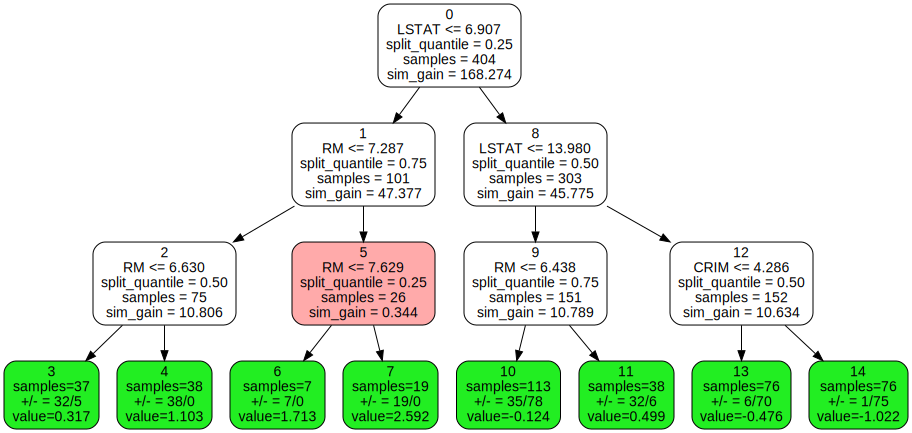

In [32]:
xdt = XGBTree()
xdt.fit(X_train, y_train)
dot_data=xdt.export_graphviz()
graph = graphviz.Source(dot_data) 
display(graph)

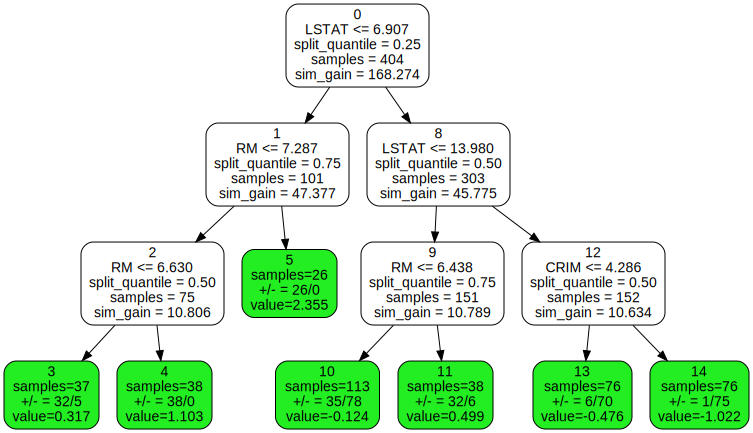

In [33]:
xdt.prune()
dot_data=xdt.export_graphviz()
graph = graphviz.Source(dot_data) 
display(graph)

In [34]:
display(xdt.score(X, y))
display(xdt.score(X_train, y_train))
display(xdt.score(X_test, y_test))

0.7122572081276021

0.7509138990936385

0.5611754222602993

## Step 1 Average

In [90]:
#now let's get started
learning_rate=0.3
loss = [0] * 6
residuals = np.zeros([6,n_train])
predictoin = np.zeros([6,n_train])
#calculation
#average_y=y.mean()
predictoin[0] = [0.5] * n_train
residuals[0] = y_train - predictoin[0]
df_train['$f_0$']=np.array(predictoin[0]).reshape((-1, 1))
df_train['$r_0$']=np.array(residuals[0]).reshape((-1, 1))
display(df)
loss[0] = np.sum(residuals[0] ** 2)
trees = []

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ONE,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,1,0.159686
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,1,-0.101524
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,1,1.324247
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1,1.182758
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,1,1.487503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,1,-0.014454
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,1,-0.210362
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,1,0.148802
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,1,-0.057989


In [91]:
predictoin[0].shape

(404,)

In the first step, we calculate the average 71.2 as the initial prediction. The pseudo residuals are 16.8, 4.8, etc.

## Step 2 For Loop

In [92]:
def iterate(i):
    t = XGBTree(max_depth=3, gamma=5)
    t.fit(X_train,residuals[i])
    trees.append(t)
    
    dot_data = t.export_graphviz()
    graph = graphviz.Source(dot_data) 
    display(graph)
    t.prune()
    dot_data = t.export_graphviz()
    graph = graphviz.Source(dot_data) 
    display(graph)
    #next prediction, residual
    predictoin[i+1]=predictoin[i]+learning_rate * t.predict(X_train)
    residuals[i+1]=y_train-predictoin[i+1]
    loss[i+1] = np.sum(residuals[i+1] ** 2)/n_train
    y_hat=t.predict(X_train)
    df_train[f'$\gamma_{i+1}$']=y_hat.reshape((-1,1))
    df_train[f'$f_{i+1}$']=np.array(predictoin[i+1]).reshape((-1,1))
    df_train[f'$r_{i+1}$']=np.array(residuals[i+1]).reshape((-1,1))
    if i==0:
        display(df_train[[f'$f_{i}$',f'$r_{i}$',f'$\gamma_{i+1}$',f'$f_{i+1}$',f'$r_{i+1}$']])
    else:
        display(df_train[["PRICE",f'$f_{i}$',f'$r_{i}$',f'$\gamma_{i+1}$',f'$f_{i+1}$',f'$r_{i+1}$']])
    

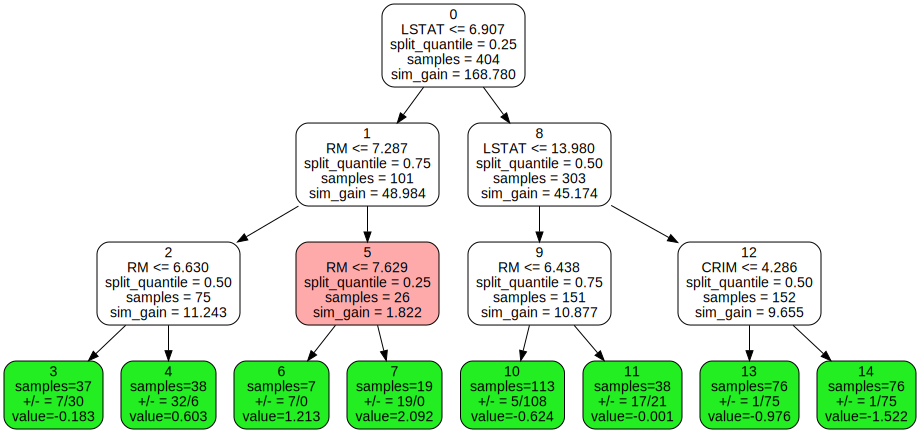

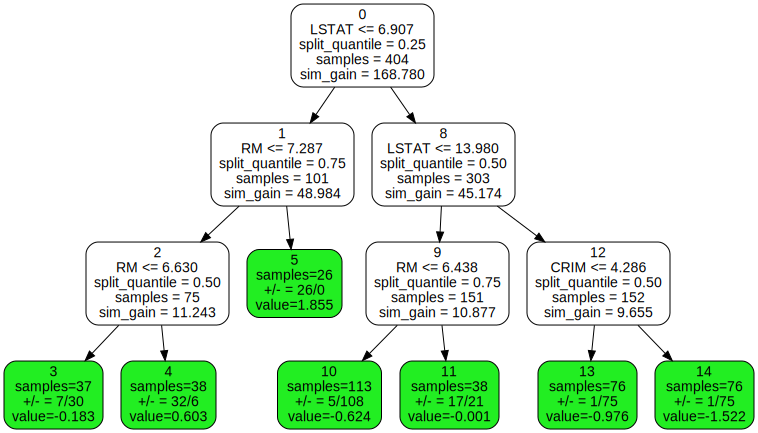

,$f_0$,$r_0$,$\gamma_1$,$f_1$,$r_1$
0,0.5,0.290943,-0.183235,0.445029,0.345914
1,0.5,-0.666827,-0.624448,0.312666,-0.479493
2,0.5,-0.819199,-0.624448,0.312666,-0.631865
3,0.5,-0.971572,-0.624448,0.312666,-0.784237
4,0.5,2.489460,0.602848,0.680854,2.308606
...,...,...,...,...,...
399,0.5,-0.938920,-0.624448,0.312666,-0.751586
400,0.5,-0.557989,-0.624448,0.312666,-0.370655
401,0.5,0.095036,0.602848,0.680854,-0.085819
402,0.5,0.367129,0.602848,0.680854,0.186275


In [93]:
iterate(0)

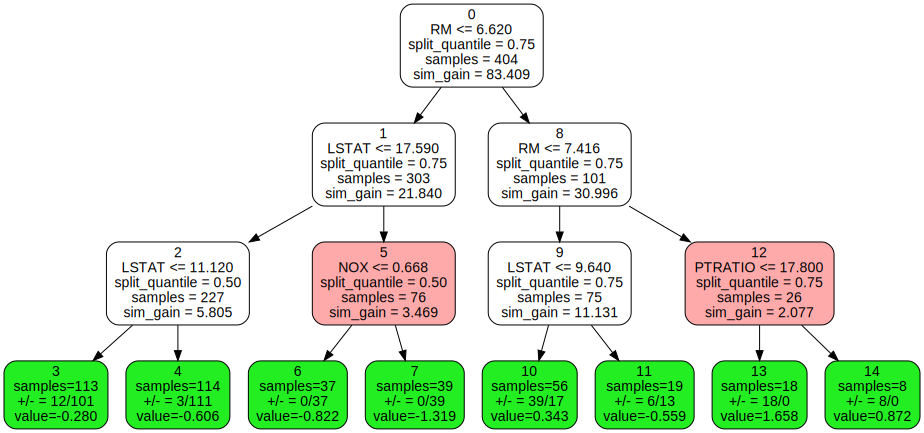

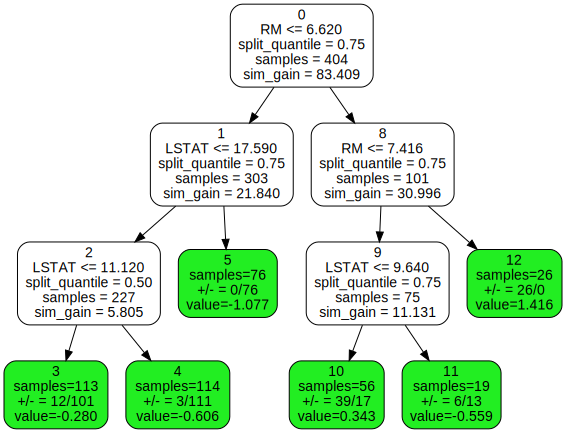

,PRICE,$f_1$,$r_1$,$\gamma_2$,$f_2$,$r_2$
0,0.790943,0.445029,0.345914,-0.279922,0.361053,0.429890
1,-0.166827,0.312666,-0.479493,-0.606451,0.130730,-0.297557
2,-0.319199,0.312666,-0.631865,-0.606451,0.130730,-0.449930
3,-0.471572,0.312666,-0.784237,-0.279922,0.228689,-0.700261
4,2.989460,0.680854,2.308606,0.342607,0.783637,2.205823
...,...,...,...,...,...,...
399,-0.438920,0.312666,-0.751586,-0.279922,0.228689,-0.667610
400,-0.057989,0.312666,-0.370655,-0.279922,0.228689,-0.286678
401,0.595036,0.680854,-0.085819,0.342607,0.783637,-0.188601
402,0.867129,0.680854,0.186275,0.342607,0.783637,0.083493


In [94]:
iterate(1)

In iteration 1, we firstly train a tree using residuals_1. This tree tells us height is also important in determining weight. Whose who are less than 1.55 meters are supported to lose -7.289 and the other to gain 7.289. Again, we want to shrink this to 20%, which is -1.4578 and 1.4578. We then make prediction_2 based on prediction_1 and $\gamma$. We see Alex gains 1.4578 kg because he is 1.6. Others also gain or lose weight because of the new rule.

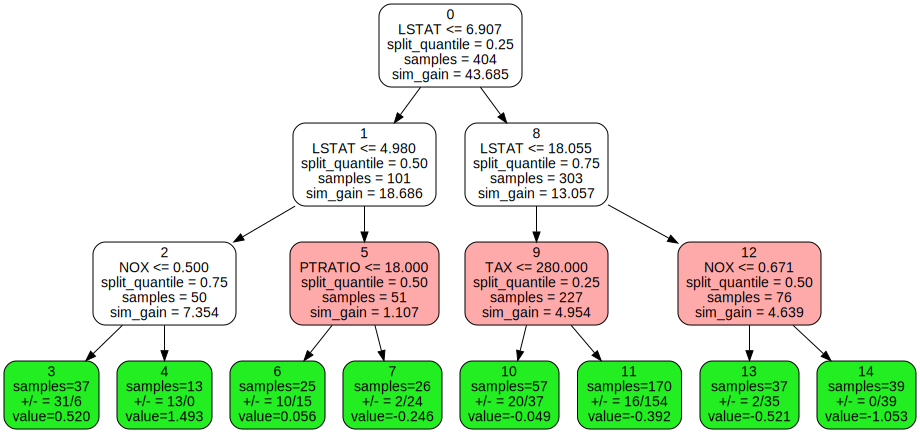

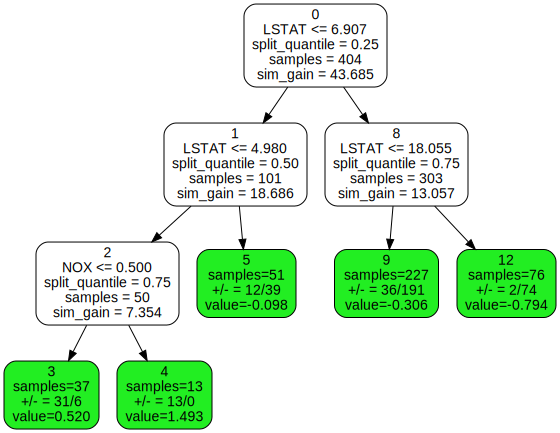

,PRICE,$f_2$,$r_2$,$\gamma_3$,$f_3$,$r_3$
0,0.790943,0.361053,0.429890,0.520445,0.517186,0.273757
1,-0.166827,0.130730,-0.297557,-0.305584,0.039055,-0.205882
2,-0.319199,0.130730,-0.449930,-0.305584,0.039055,-0.358255
3,-0.471572,0.228689,-0.700261,-0.305584,0.137014,-0.608586
4,2.989460,0.783637,2.205823,1.493132,1.231576,1.757884
...,...,...,...,...,...,...
399,-0.438920,0.228689,-0.667610,-0.305584,0.137014,-0.575934
400,-0.057989,0.228689,-0.286678,-0.305584,0.137014,-0.195003
401,0.595036,0.783637,-0.188601,-0.098053,0.754221,-0.159185
402,0.867129,0.783637,0.083493,0.520445,0.939770,-0.072641


In [95]:
iterate(2)

Iteration 2 again tells us that gender matters.

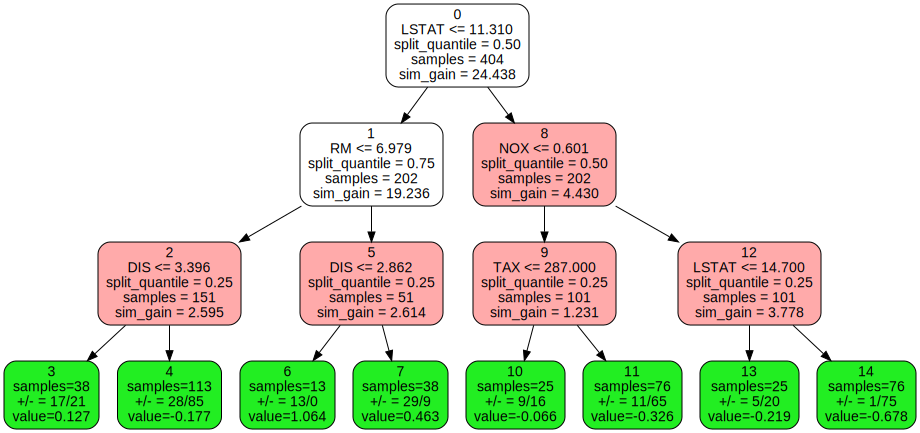

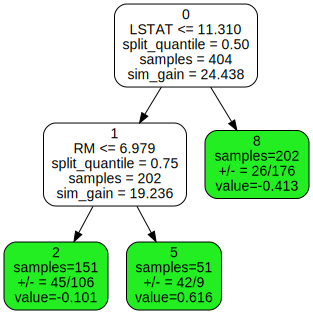

,PRICE,$f_3$,$r_3$,$\gamma_4$,$f_4$,$r_4$
0,0.790943,0.517186,0.273757,-0.100823,0.486939,0.304004
1,-0.166827,0.039055,-0.205882,-0.413125,-0.084882,-0.081945
2,-0.319199,0.039055,-0.358255,-0.413125,-0.084882,-0.234317
3,-0.471572,0.137014,-0.608586,-0.100823,0.106767,-0.578339
4,2.989460,1.231576,1.757884,-0.100823,1.201329,1.788131
...,...,...,...,...,...,...
399,-0.438920,0.137014,-0.575934,-0.100823,0.106767,-0.545687
400,-0.057989,0.137014,-0.195003,-0.100823,0.106767,-0.164756
401,0.595036,0.754221,-0.159185,-0.100823,0.723974,-0.128938
402,0.867129,0.939770,-0.072641,-0.100823,0.909523,-0.042394


In [96]:
iterate(3)

Iteration 3 argues that height is important, too.

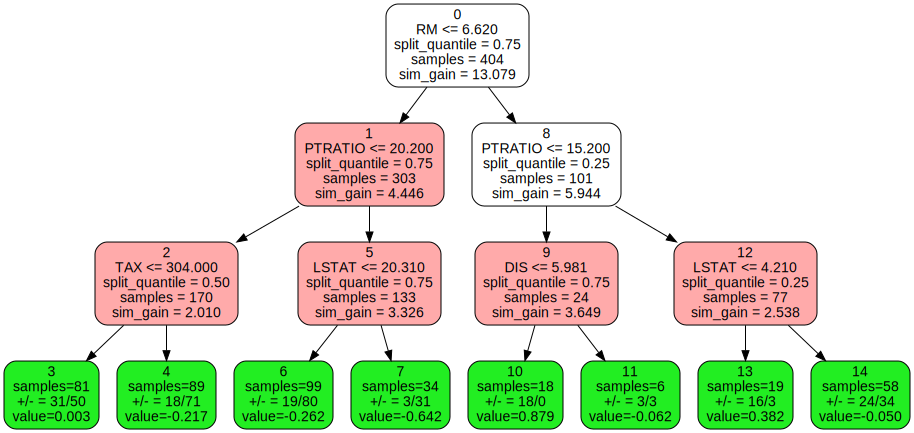

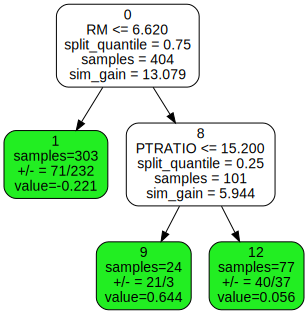

,PRICE,$f_4$,$r_4$,$\gamma_5$,$f_5$,$r_5$
0,0.790943,0.486939,0.304004,-0.220671,0.420738,0.370205
1,-0.166827,-0.084882,-0.081945,-0.220671,-0.151084,-0.015743
2,-0.319199,-0.084882,-0.234317,-0.220671,-0.151084,-0.168116
3,-0.471572,0.106767,-0.578339,-0.220671,0.040566,-0.512137
4,2.989460,1.201329,1.788131,0.056497,1.218278,1.771182
...,...,...,...,...,...,...
399,-0.438920,0.106767,-0.545687,-0.220671,0.040566,-0.479486
400,-0.057989,0.106767,-0.164756,-0.220671,0.040566,-0.098555
401,0.595036,0.723974,-0.128938,0.056497,0.740923,-0.145887
402,0.867129,0.909523,-0.042394,0.056497,0.926472,-0.059343


In [97]:
iterate(4)

Let's stop at Iteration 4. And take a look at the loss.

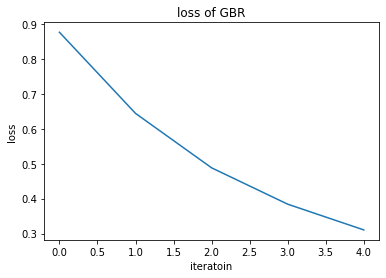

In [75]:
plt.plot(loss[1:])
plt.title('loss of XBR')
plt.xlabel('iteratoin')
plt.ylabel('loss')
plt.show()

Hope you get the idea.

# Reference:

https://en.wikipedia.org/wiki/Gradient_boosting

https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=44    

https://www.youtube.com/watch?v=2xudPOBz-vs&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=45

This article is based on this video.